In [182]:
import itertools
import functools
from zipfile import ZipFile
import time

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_predict, cross_val_score

import spacy
from nltk.corpus import wordnet as wn

%matplotlib inline

In [3]:
nlp = spacy.load('en_core_web_md', disable=['ner', 'textcat'])

In [4]:
with ZipFile('snli_1.0.zip') as archive:
    names = archive.namelist()
    print('\n'.join([name for name in names if '.DS' not in name and '__MACOSX' not in name]))
    df_dev = pd.read_json(archive.open("snli_1.0/snli_1.0_dev.jsonl"), lines=True)
    df_test = pd.read_json(archive.open("snli_1.0/snli_1.0_test.jsonl"), lines=True)
    df_train = pd.read_json(archive.open("snli_1.0/snli_1.0_train.jsonl"), lines=True)

snli_1.0/
snli_1.0/Icon
snli_1.0/README.txt
snli_1.0/snli_1.0_dev.jsonl
snli_1.0/snli_1.0_dev.txt
snli_1.0/snli_1.0_test.jsonl
snli_1.0/snli_1.0_test.txt
snli_1.0/snli_1.0_train.jsonl
snli_1.0/snli_1.0_train.txt


In [5]:
def remove_unset(df):
    new_df = df[df['gold_label'] != '-'].copy().reset_index()
    return new_df
df_dev = remove_unset(df_dev)
df_test = remove_unset(df_test)
df_train = remove_unset(df_train)

In [6]:
df_dev.shape, df_test.shape, df_train.shape

((9842, 11), (9824, 11), (549367, 11))

In [7]:
eda = df_dev.copy()
eda = eda[['gold_label', 'sentence1', 'sentence2']]

In [7]:
eda['sent1_len'] = eda['sentence1'].str.len()
eda['sent2_len'] = eda['sentence2'].str.len()
eda.head(3)

,gold_label,sentence1,sentence2,sent1_len,sent2_len
0,neutral,Two women are embracing while holding to go pa...,The sisters are hugging goodbye while holding ...,53,85
1,entailment,Two women are embracing while holding to go pa...,Two woman are holding packages.,53,31
2,contradiction,Two women are embracing while holding to go pa...,The men are fighting outside a deli.,53,36


In [8]:
eda.describe()

,sent1_len,sent2_len
count,9842.000000,9842.000000
mean,72.250457,37.897887
std,32.890431,16.385647
min,13.000000,6.000000
25%,48.000000,27.000000
50%,64.000000,35.000000
75%,93.000000,45.000000
max,300.000000,232.000000


In [9]:
eda.sort_values('sent2_len')

,gold_label,sentence1,sentence2,sent1_len,sent2_len
1064,entailment,A sleeping toddler has toppled out of his crib.,A baby,47,6
7946,contradiction,The brown dog next to the swimming pool has a ...,A dog died,64,10
8819,entailment,"A man sitting at a desk, repairing antique typ...",a man sits,55,10
3903,entailment,A group of men are seated around a table and e...,Men eating,52,10
4615,contradiction,A large group of people walking down a city st...,a man sits,51,10
8094,contradiction,An Asian man attempting to repair a green bicy...,Just a bike,94,11
8091,entailment,An Asian man attempting to repair a green bicy...,Some humans,94,11
9781,contradiction,A West Virginia university women's basketball ...,a dog barks,122,11
26,contradiction,A young boy in a field of flowers carrying a ball,dog in pool,49,11
9477,contradiction,Two black and white dogs looking at a black an...,No animals.,110,11


In [10]:
eda['gold_label'].value_counts()

entailment       3329
contradiction    3278
neutral          3235
Name: gold_label, dtype: int64

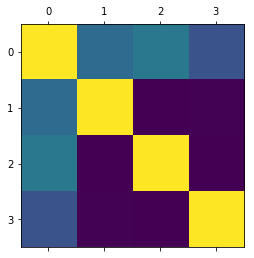

In [11]:
subset = eda[['gold_label', 'sent1_len', 'sent2_len']].copy()
subset['diff'] = subset['sent1_len'] - subset['sent2_len']
df_dummies = pd.get_dummies(subset['gold_label'])

subset = pd.concat([subset, df_dummies], axis=1)
del subset['gold_label']
plt.matshow(subset[['diff', 'contradiction', 'entailment', 'neutral']].corr(method='spearman'))
# seems that there's no obvious correlation between difference of lengths between between sentences
# (yet biggest one is for neutral class)

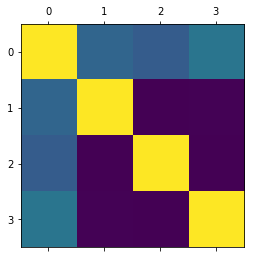

In [12]:
subset['sum'] = subset['sent1_len'] + subset['sent2_len']
plt.matshow(subset[['sum', 'contradiction', 'entailment', 'neutral']].corr(method='spearman'))
# same for sum of lengths, although this time neutral and positive seems more correlated, yet not significantly

In [52]:
@functools.lru_cache(maxsize=5000)
def run_nlp(sentence):
    return nlp(sentence)


# Baseline

### 1st idea - overlapping lemmas
let's count overlapping lemmas, skipping stop words and IN/DT

In [14]:

def is_meaningful(tok):
    if tok.is_stop:
        return False
    if tok.is_punct:
        return False
    if tok.tag_ in ['IN', 'DT']:
        return False
    return True
def get_basic_form(tok):
    if tok.lemma_.startswith('-') and tok.lemma_.endswith('-'):
        return str(tok)
    else:
        return tok.lemma_
def overlapping_words(row):
    given_doc = run_nlp(row['sentence1'].lower())
    hypothesis_doc = run_nlp(row['sentence2'].lower())
    given_words = set([get_basic_form(tok) for tok in given_doc if is_meaningful(tok)])
    hypot_words = set([get_basic_form(tok) for tok in hypothesis_doc if is_meaningful(tok)])
    return set(given_words) & set(hypot_words)

def to_len_X(df):
    return df.apply(lambda r: len(overlapping_words(r)), axis=1)

def reshape_x(X):
    return X.values.reshape((len(X),1))

In [15]:
X_len_train = reshape_x(to_len_X(df_train))
y_len_train = df_train['gold_label']
X_len_dev = reshape_x(to_len_X(df_dev))
y_len_dev = df_dev['gold_label']

In [16]:
predictor = LogisticRegression()
predictor.fit(X_len_train, y_len_train)
y_predicted = predictor.predict(X_len_dev)
print(metrics.classification_report(y_len_dev, y_predicted))

               precision    recall  f1-score   support

contradiction       0.42      0.76      0.54      3278
   entailment       0.46      0.53      0.50      3329
      neutral       0.00      0.00      0.00      3235

  avg / total       0.30      0.44      0.35      9842



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


First I tried memoizing spacy's work and jupyter just ate all the available RAM and swapped into 0 bytes left on disk. After heroically fighting with this issue (which took 15 minutes to recover from) I removed memoization and it took several hours to run on whole dataset, so I'm not tuning anything in this Baseline and considering this good enough

### 2nd idea - average w2v

average w2v on sentences and cosine similiarity.

In [26]:
def to_similarity_X(row):
    given_doc = run_nlp(row['sentence1'].lower())
    hypothesis_doc = run_nlp(row['sentence2'].lower())
    return pd.Series({'given->hypo': given_doc.similarity(hypothesis_doc), 
                      'hypo->given': hypothesis_doc.similarity(given_doc) })

In [24]:
X_sim_train = df_train.apply(to_similarity_X, axis=1)
y_sim_train = df_train['gold_label']
X_sim_dev = df_dev.apply(to_similarity_X, axis=1)
y_sim_dev = df_dev['gold_label']

In [25]:
predictor = LogisticRegression()
predictor.fit(X_sim_train, y_sim_train)
y_predicted = predictor.predict(X_sim_dev)
print(metrics.classification_report(y_sim_dev, y_predicted))

               precision    recall  f1-score   support

contradiction       0.43      0.56      0.49      3278
   entailment       0.42      0.64      0.51      3329
      neutral       0.35      0.05      0.09      3235

  avg / total       0.40      0.42      0.36      9842



# Further work

Okay, let's try to use wordnet and compare following parts if they are present, or just leave those present both in given and hypothesis doc

1. root verb
2. root verb + subject
3. root + subject + object

In [54]:
sent1, sent2 = df_train[0:1]['sentence1'][0], df_train[0:1]['sentence2'][0]

In [55]:
given_doc = run_nlp(sent1)
hypot_doc = run_nlp(sent2)

In [56]:
print(given_doc)

A person on a horse jumps over a broken down airplane.


In [57]:
[tok.dep_ for tok in given_doc]

['det',
 'nsubj',
 'prep',
 'det',
 'pobj',
 'ROOT',
 'prep',
 'det',
 'amod',
 'prt',
 'pobj',
 'punct']

In [58]:
# A person on a horse jumps over a broken down airplane.
# ['det','ROOT','prep','det','compound','pobj','prep','det','amod','prt','pobj','punct']
# Okay, at this point I thought I want a better model given that 'jumps' was marked as pobj
# I would rerun baseline if it didn't take just awfully large amount of time

In [59]:
nlp = spacy.load('en_core_web_lg', disable=['ner', 'textcat'])

In [60]:
sub_toks = [tok for tok in given_doc if (tok.dep_ == "nsubj") ]
print(given_doc)
print(sub_toks) 

A person on a horse jumps over a broken down airplane.
[person]


In [93]:
def get_corresponding_synsets(word, pos):
    all_syns = wn.synsets(word)
    # n for noun files, v for verb files, a for adjective files, r
    pos_to_wn = {
        'NOUN': 'n',
        'ADJ': 'a',
        'ADV': 'r',
        'VERB': 'v'
    }
    if pos in pos_to_wn:
        key = '.' + pos_to_wn[pos] + '.'
    else:
        key = str(word)
    filtered_syns = [syn for syn in all_syns if key in str(syn)]
    if len(filtered_syns) == 0:
        filtered_syns = all_syns 
    return filtered_syns

In [169]:
def get_minmax_similarity(type_fn, synset1, synset2):
    max_sim = -1000
    min_sim = 10000
    assert type_fn in ['path', 'lch', 'wup']
    if len(synset1) == 0 or len(synset2) == 0:
        return max_sim, min_sim # inverting this to give some new signal to classifier
    assert len(synset1) > 0
    assert len(synset2) > 0

    for pair in itertools.product(synset1, synset2):
        if type_fn == 'path':
            value = pair[0].path_similarity(pair[1])
        # lch seems to work too long, will be skipping
        elif type_fn == 'lch':
            value = pair[0].lch_similarity(pair[1])
        elif type_fn == 'wup':
            value = pair[0].wup_similarity(pair[1])
        if not value is None and value > max_sim:
            max_sim = value
        if not value is None and value < min_sim:
            min_sim = value
    return min_sim, max_sim 

In [170]:
# took some of the things from cool example – https://github.com/NSchrading/intro-spacy-nlp/blob/master/subject_object_extraction.py
SUBJECTS = ["nsubj", "nsubjpass", "csubj", "csubjpass", "agent", "expl"]
OBJECTS = ["dobj", "dative", "attr", "oprd"]

def safe_first(the_list):
    try:
        return the_list[0]
    except IndexError:
        return None
def get_root(doc):
    return safe_first([token for token in doc if token.dep_ == 'ROOT'])

def get_first_nsubj(doc):
    return safe_first([token for token in doc if token.dep_ in SUBJECTS])

def get_first_obj(doc):
    return safe_first([token for token in doc if token.dep_ in OBJECTS])

def get_matching_parts(doc1, doc2):
    root1, nsubj1, obj1 = get_root(doc1), get_first_nsubj(doc1), get_first_obj(doc1)
    root2, nsubj2, obj2 = get_root(doc2), get_first_nsubj(doc2), get_first_obj(doc2)
    if all([root1, nsubj1, obj1, root2, nsubj2, obj2]):
        return [root1, nsubj1, obj1], [root2, nsubj2, obj2]
    if all([root1, nsubj1, root2, nsubj2]):
        return [root1, nsubj1], [root2, nsubj2]
    return [root1], [root2]

def to_wn_X(row):
    given_doc = run_nlp(row['sentence1'].lower())
    hypot_doc = run_nlp(row['sentence2'].lower())
    given_parts, hypot_parts = get_matching_parts(given_doc, hypot_doc)
    labels = ['root', 'nsubj', 'obj']
    res = {}
    for i, pair in enumerate(zip(given_parts, hypot_parts)):
        label = labels[i]
        res[f'{label}_given'] = str(pair[0])
        res[f'{label}_hypot'] = str(pair[1])
        res[f'{label}_w2v'] = pair[0].similarity(pair[1])
        given_synset = get_corresponding_synsets(str(pair[0]), pair[0].pos_)
        hypot_synset = get_corresponding_synsets(str(pair[1]), pair[1].pos_)
        for metric in ['path', 'wup']:
            min_sim, max_sim = get_minmax_similarity(metric, given_synset, hypot_synset)
            res[f'{label}_min_{metric}'] = min_sim
            res[f'{label}_max_{metric}'] = max_sim
    return pd.Series(res)
# path_similarity
# lch_similarity
# wup_similarity


Well, wordnet one works not that well if we are trying to compare noun and verb
Also, if we are taking present continuous and regular verb, we are gonna compare verb & 'is/are' which is not that great.

In [171]:
start = time.time()
train_X = df_train.apply(to_wn_X, axis=1).fillna(0)
print(f'took {time.time() - start:.2f} sec')
train_X.head(5)

took 21449.60 sec


,nsubj_given,nsubj_hypot,nsubj_max_path,nsubj_max_wup,nsubj_min_path,nsubj_min_wup,nsubj_w2v,obj_given,obj_hypot,obj_max_path,...,obj_min_path,obj_min_wup,obj_w2v,root_given,root_hypot,root_max_path,root_max_wup,root_min_path,root_min_wup,root_w2v
0,person,person,1.0,1.0,0.071429,0.133333,1.0,0,0,0.0,...,0.0,0.0,0.0,jumps,training,0.250000,0.4,0.083333,0.153846,0.229022
1,person,person,1.0,1.0,0.071429,0.133333,1.0,0,0,0.0,...,0.0,0.0,0.0,jumps,is,0.333333,0.5,0.062500,0.117647,0.215992
2,person,person,1.0,1.0,0.071429,0.133333,1.0,0,0,0.0,...,0.0,0.0,0.0,jumps,is,0.333333,0.5,0.062500,0.117647,0.215992
3,0,0,0.0,0.0,0.000000,0.000000,0.0,0,0,0.0,...,0.0,0.0,0.0,children,smiling,-1000.000000,-1000.0,10000.000000,10000.000000,0.301850
4,0,0,0.0,0.0,0.000000,0.000000,0.0,0,0,0.0,...,0.0,0.0,0.0,children,are,-1000.000000,-1000.0,10000.000000,10000.000000,0.428350


In [172]:
start = time.time()
dev_X = df_dev.apply(to_wn_X, axis=1).fillna(0)
print(f'took {time.time() - start:.2f} sec')
dev_X.head(5)

took 376.80 sec


,nsubj_given,nsubj_hypot,nsubj_max_path,nsubj_max_wup,nsubj_min_path,nsubj_min_wup,nsubj_w2v,obj_given,obj_hypot,obj_max_path,...,obj_min_path,obj_min_wup,obj_w2v,root_given,root_hypot,root_max_path,root_max_wup,root_min_path,root_min_wup,root_w2v
0,women,sisters,0.333333,0.900000,0.076923,0.142857,0.448654,packages,goodbye,0.111111,...,0.071429,0.133333,0.092406,embracing,hugging,1.000000,1.000000,0.111111,0.200000,0.450882
1,women,woman,1.000000,1.000000,0.066667,0.125000,0.717893,packages,packages,1.000000,...,0.066667,0.125000,1.000000,embracing,holding,0.333333,0.571429,0.090909,0.166667,0.350139
2,women,men,0.333333,0.705882,0.052632,0.100000,0.825095,0,0,0.000000,...,0.000000,0.000000,0.000000,embracing,fighting,0.250000,0.400000,0.090909,0.166667,0.333160
3,children,kids,1.000000,1.000000,0.062500,0.235294,0.814095,hands,hands,1.000000,...,0.043478,0.083333,1.000000,standing,wash,0.500000,0.857143,0.083333,0.153846,0.280723
4,children,kids,1.000000,1.000000,0.062500,0.235294,0.814095,hands,hands,1.000000,...,0.043478,0.083333,1.000000,standing,wash,0.500000,0.857143,0.083333,0.153846,0.280723


In [175]:
y_train = df_train['gold_label']
y_dev = df_dev['gold_label']

In [ ]:
# just so we don't overfit on y_dev, let's use cross_valiidation

In [213]:
def avg(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

def cross_validate(predictor, X, y):
    scores = cross_val_score(predictor, X, y, scoring='accuracy', cv=5)
    print(avg(scores), '<-', scores)
    y_pred = cross_val_predict(predictor, X, y, cv=5)
    predictor.fit(X, y)
    return metrics.classification_report(y, y_pred, labels=('entailment', 'neutral', 'contradiction'))

In [214]:
features_set = [
    ['root_w2v'],
    ['root_w2v', 'nsubj_w2v'],
    ['root_w2v', 'nsubj_w2v', 'obj_w2v'],
    ['root_min_path', 'root_max_path'],
    ['root_min_path', 'root_max_path', 'nsubj_min_path', 'nsubj_max_path'],
    ['root_min_path', 'root_max_path', 'nsubj_min_path', 'nsubj_max_path', 'obj_min_path', 'obj_max_path'],
    ['root_min_wup', 'root_max_wup'],
    ['root_min_wup', 'root_max_wup', 'nsubj_min_wup', 'nsubj_max_wup'],
    ['root_min_wup', 'root_max_wup', 'nsubj_min_wup', 'nsubj_max_wup', 'obj_min_wup', 'obj_max_wup'],
    ['root_w2v', 'root_min_path', 'root_max_path', 'root_min_wup', 'root_max_wup'],
    ['root_w2v', 'nsubj_w2v', 'root_min_path', 'root_max_path', 'nsubj_min_path', 'nsubj_max_path', 'root_min_wup', 'root_max_wup', 'nsubj_min_wup', 'nsubj_max_wup'],
    ['root_w2v', 'nsubj_w2v', 'obj_w2v', 'root_min_path', 'root_max_path', 'nsubj_min_path', 'nsubj_max_path', 'obj_min_path', 'obj_max_path', 'root_min_wup', 'root_max_wup', 'nsubj_min_wup', 'nsubj_max_wup', 'obj_min_wup', 'obj_max_wup'],
]
result_predictors = {}
for features in features_set:
    key = " ".join(features)
    print(f'looking at {key}')
    predictor = LogisticRegression()
    print(cross_validate(predictor, train_X[features], y_train))
    result_predictors[key] = predictor

looking at root_w2v
0.37187708008757614 <- [0.37388851 0.37090667 0.37302158 0.37078263 0.37078601]
               precision    recall  f1-score   support

   entailment       0.39      0.40      0.40    183416
      neutral       0.29      0.02      0.03    182764
contradiction       0.36      0.70      0.48    183187

  avg / total       0.35      0.37      0.30    549367

looking at root_w2v nsubj_w2v
0.37752357937057107 <- [0.37921274 0.37704097 0.37748127 0.37723554 0.37664737]
               precision    recall  f1-score   support

   entailment       0.40      0.42      0.41    183416
      neutral       0.35      0.06      0.10    182764
contradiction       0.37      0.65      0.47    183187

  avg / total       0.37      0.38      0.33    549367

looking at root_w2v nsubj_w2v obj_w2v
0.38410024601508846 <- [0.38553811 0.3820012  0.38483522 0.38339719 0.3847295 ]
               precision    recall  f1-score   support

   entailment       0.40      0.42      0.41    183416
     

There's no single entry better than our baseline. There are some that have better precision that baselines and also final one with all features does preform better in term of f1 score. Let's see how that one performs on dev set.

In [219]:
features = features_set[-1]
best_predictor = result_predictors['root_w2v nsubj_w2v obj_w2v root_min_path root_max_path nsubj_min_path nsubj_max_path obj_min_path obj_max_path root_min_wup root_max_wup nsubj_min_wup nsubj_max_wup obj_min_wup obj_max_wup']
best_predictor

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [221]:
y_predicted = best_predictor.predict(dev_X[features])
print(metrics.classification_report(y_dev, y_predicted))

               precision    recall  f1-score   support

contradiction       0.38      0.61      0.47      3278
   entailment       0.45      0.40      0.42      3329
      neutral       0.34      0.17      0.23      3235

  avg / total       0.39      0.40      0.37      9842



As we see, this is slightly better than original baseline in terms of f1. Improvement here, mainly, seems to be caused by better handling of neutral cases. And one thing we should be remembering - initial baselines were ran with smaller spacy model, so actually they might be performing even better.